In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data2/Sdf16_1a.txt', sep='\t')
df.head()

,LEAID,CENSUSID,FIPST,CONUM,CSA,CBSA,NAME,STNAME,STABBR,SCHLEV,...,FL_61V,FL_66V,FL_W01,FL_W31,FL_W61,FL_V95,FL_V02,FL_K14,FL_CE1,FL_CE2
0,100002,N,1,01073,142,13820,Alabama Youth Services,Alabama,AL,N,...,M,M,M,M,M,M,M,M,M,M
1,100005,01504840100000,1,01095,290,10700,Albertville City,Alabama,AL,03,...,M,M,R,R,R,M,M,M,M,M
2,100006,01504800100000,1,01095,290,10700,Marshall County,Alabama,AL,03,...,M,M,R,R,R,M,M,M,M,M
3,100007,01503740100000,1,01073,142,13820,Hoover City,Alabama,AL,03,...,M,M,R,R,R,M,M,M,M,M
4,100008,01504530100000,1,01089,290,26620,Madison City,Alabama,AL,03,...,M,M,R,R,R,M,M,M,M,M


In [4]:
language_df = pd.read_csv('../data2/rla-achievement-lea-sy2016-17.csv')
language_df = language_df[language_df['ALL_RLA00PCTPROF_1617'].str.contains('PS') == False]
language_df.head()

,STNAM,FIPST,LEAID,ST_LEAID,LEANM,DATE_CUR,ALL_RLA00NUMVALID_1617,ALL_RLA00PCTPROF_1617,MAM_RLA00NUMVALID_1617,MAM_RLA00PCTPROF_1617,...,MIG_RLA05NUMVALID_1617,MIG_RLA05PCTPROF_1617,MIG_RLA06NUMVALID_1617,MIG_RLA06PCTPROF_1617,MIG_RLA07NUMVALID_1617,MIG_RLA07PCTPROF_1617,MIG_RLA08NUMVALID_1617,MIG_RLA08PCTPROF_1617,MIG_RLAHSNUMVALID_1617,MIG_RLAHSPCTPROF_1617
0,ALABAMA,1,100005,AL-101,Albertville City,12APR18,2797,28,3,PS,...,22,LE20,22,LE20,18,21-39,14,LT50,20,LE20
1,ALABAMA,1,100006,AL-048,Marshall County,12APR18,2969,34,11,GE50,...,5,PS,4,PS,1,PS,3,PS,3,PS
2,ALABAMA,1,100007,AL-158,Hoover City,12APR18,7421,58,8,LT50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALABAMA,1,100008,AL-169,Madison City,12APR18,5578,69,33,60-69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALABAMA,1,100011,AL-167,Leeds City,12APR18,997,33,3,PS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
membership = pd.read_csv('../data2/ccd_lea_052_1516_w_1a_011717.csv')
membership.head()

,SURVYEAR,FIPST,STABR,STATENAME,SEANAME,LEAID,ST_LEAID,LEA_NAME,PK,KG,...,BLALF,WH,WHALM,WHALF,HP,HPALM,HPALF,TR,TRALM,TRALF
0,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100002,210,Alabama Youth Services,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100005,101,Albertville City,118,491,...,68,2619,1310,1309,4,0,4,119,66,53
2,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100006,48,Marshall County,154,380,...,24,4331,2228,2103,2,1,1,49,28,21
3,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100007,158,Hoover City,65,942,...,1724,8131,4230,3901,14,5,9,275,140,135
4,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100008,169,Madison City,156,596,...,959,6186,3187,2999,27,14,13,393,182,211


In [6]:
disable = pd.read_csv('../data2/ccd_lea_002089_1516_w_1a_011717.csv')
disable.head()

,SURVYEAR,FIPST,STABR,STATENAME,SEANAME,LEAID,ST_LEAID,LEA_NAME,SPECED
0,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100002,210,Alabama Youth Services,24
1,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100005,101,Albertville City,267
2,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100006,048,Marshall County,430
3,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100007,158,Hoover City,861
4,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100008,169,Madison City,735


In [7]:
def parseScore(sc):
    try:
         return int(sc)
    except:
        if '-' in sc:
            x = sc.split('-')
        elif 'LE' in sc or 'LT' in sc:
            x = [0, sc[2:]]
        else:
            x = [100, sc[2:]]
        return (int(x[0]) + int(x[1])) // 2
language_df['ParsedScores'] = language_df['ALL_RLA00PCTPROF_1617'].apply(parseScore)

In [8]:
budget = np.sum(df['TFEDREV'].values)
cut = int(budget * 0.15)
cutting_df = pd.merge(df[['LEAID', 'TFEDREV']], language_df[['LEAID', 'ParsedScores']], on='LEAID')
cutting_df = cutting_df[cutting_df['TFEDREV'] > 0]
top = cutting_df[cutting_df['ParsedScores'] > \
                   (np.mean(cutting_df['ParsedScores']) - np.std(cutting_df['ParsedScores']))]
top['Rate'] = (top['TFEDREV'] * 0.25) + (top['ParsedScores'] * 0.75)
total = np.sum(top['Rate'])
top['Normalized'] = top['Rate'] / total
top['BudgetCut'] = round(top['Normalized'] * cut, 2)
top['NewBudget'] = top['TFEDREV'] - top['BudgetCut']

In [9]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height-0.1,
                height,
                ha='center', va='bottom')

# Problem 1
#### For the districts you selected for budget cuts in HW 3 Problem 4, calculate and visualize the proportion of each district’s total funding that will be lost. Which districts will be affected by your budget cuts the most?

In [10]:
top['BudgetCutProp'] = top['BudgetCut'] / top['TFEDREV'] 

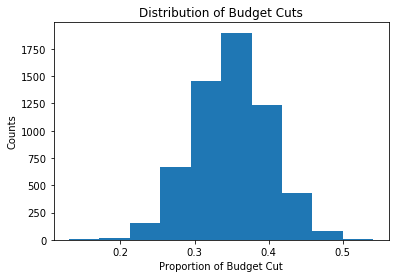

In [11]:
plt.hist(top['BudgetCutProp'])
plt.title('Distribution of Budget Cuts')
plt.xlabel('Proportion of Budget Cut')
plt.ylabel('Counts')
plt.savefig('Q1.png')
plt.show()

In [12]:
print('Most affected by budget cut :')
top[top['BudgetCutProp'] == max(top['BudgetCutProp'])]

Most affected by budget cut :


,LEAID,TFEDREV,ParsedScores,Rate,Normalized,BudgetCut,NewBudget,BudgetCutProp
2343,2600121,2000,77,557.75,1.317457e-07,1098.81,901.19,0.549405


# Problem 2

#### A common problem with purely data-driven solutions is that they can inadvertently perpetuate hidden pre-existing biases in the data, and further disadvantage groups that are already disadvantaged. Calculate the proportion of enrolled students by race for each district, then visualize the distributions of these for districts that received budget cuts versus districts that did not receive budget cuts. Comment on whether the the distributions appear to be the same or different. Did your selection include any hidden biases, or manage to avoid them?

In [13]:
q2 = pd.merge(budget_cuts, membership, on='LEAID')
q2.head()

NameError: name 'budget_cuts' is not defined

In [ ]:
q2_nocut = q2[q2['BudgetCutProp'] == 0]
q2_cut = q2[q2['BudgetCutProp'] > 0]

In [ ]:
q2_nocut = q2_nocut[['V33', 'AM', 'AS','HI', 'BL', 'WH', 'HP', 'TR', 'TOTAL']].sum()
q2_nocut['BLP'] = q2_nocut['BL'] / q2_nocut['TOTAL']
q2_nocut['AMP'] = q2_nocut['AM'] / q2_nocut['TOTAL']
q2_nocut['HPP'] = q2_nocut['HP'] / q2_nocut['TOTAL']
q2_nocut['ASP'] = q2_nocut['AS'] / q2_nocut['TOTAL']
q2_nocut['WHP'] = q2_nocut['WH'] / q2_nocut['TOTAL']
q2_nocut['HIP'] = q2_nocut['HI'] / q2_nocut['TOTAL']
q2_nocut['TRP'] = q2_nocut['TR'] / q2_nocut['TOTAL']

In [ ]:
q2_cut = q2_cut[['V33', 'AM', 'AS','HI', 'BL', 'WH', 'HP', 'TR', 'TOTAL']].sum()
q2_cut['BLP'] = q2_cut['BL'] / q2_cut['TOTAL']
q2_cut['AMP'] = q2_cut['AM'] / q2_cut['TOTAL']
q2_cut['HPP'] = q2_cut['HP'] / q2_cut['TOTAL']
q2_cut['ASP'] = q2_cut['AS'] / q2_cut['TOTAL']
q2_cut['WHP'] = q2_cut['WH'] / q2_cut['TOTAL']
q2_cut['HIP'] = q2_cut['HI'] / q2_cut['TOTAL']
q2_cut['TRP'] = q2_cut['TR'] / q2_cut['TOTAL']

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.bar(q2_nocut.index[9:], q2_nocut[9:])
plt.title('No Budget Cut')
plt.xlabel('Race')
plt.ylabel('Race Proportion')


plt.subplot(1, 2, 2)
plt.bar(q2_cut.index[9:], q2_cut[9:], color = 'orange')

plt.title('Budget Cut')
plt.xlabel('Race')
plt.ylabel('Race Proportion')

plt.savefig('Q2.png')
plt.show()

My method for selection for budget cuts does include a bias, BLP is significantly less affected by the budget cuts and WHP is affected significantly more by budget cut. 

# Problem 3
#### Calculate the proportion of enrolled students by disability status (students with an IEP under IDEA) for each district, then visualize the distributions of these proportions for districts that received budget cuts versus districts that did not receive budget cuts. Comment on whether the the distributions appear to be the same or different. Did your selection include any hidden biases, or manage to avoid them?

In [ ]:
q3 = pd.merge(budget_cuts, disable, on='LEAID')
q3.head()

In [ ]:
q3_nocut = q3[q3['BudgetCutProp'] == 0]
q3_cut = q3[q3['BudgetCutProp'] > 0]


q3_nocut = q3_nocut[['V33', 'SPECED']]
q3_cut = q3_cut[['V33', 'SPECED']]


q3_nocut['NOSPECED'] = q3_nocut['V33'] - q3_nocut['SPECED']
q3_cut['NOSPECED'] = q3_cut['V33'] - q3_cut['SPECED']

q3_nocut = q3_nocut.sum()
q3_cut = q3_cut.sum()

q3_nocut['NOSPECEDR'] = q3_nocut['NOSPECED'] / q3_nocut['V33']
q3_nocut['SPECEDR'] = q3_nocut['SPECED'] / q3_nocut['V33']

q3_cut['NOSPECEDR'] = q3_cut['NOSPECED'] / q3_cut['V33']
q3_cut['SPECEDR'] = q3_cut['SPECED'] / q3_cut['V33']

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
x = plt.bar(['No Cut' , 'Cut'], [q3_nocut.values[3], q3_cut.values[3]])
y = plt.bar(['No Cut' , 'Cut'], [q3_nocut.values[4], q3_cut.values[4]])


autolabel(x)
autolabel(y)
plt.legend([x,y], ['Not Disabled', 'Disabled'])
plt.savefig('Q3.png')
plt.show()

There are almost negligible bias that my selection method includes when it comes to student with disabilities

# Problem 4
#### Choose and critique one of your fellow classmates’ selection of schools for budget cuts in HW 3 Problem 4 and Problem 5. What was the justification of their selection? Discuss any advantages or disadvantages of their approach.

I choose to critique Omair Shafi Ahmed's apporach. Omari uses simple apporach to reduce 20% of the highest funded school till the overall goal is achieved. This apporach seems pretty straightforward and seems like the correct thing to do, it might lead to various pitfall's like, since the expenditure cost is not taken into the district already has high cost of operation hence the high budget or the high funded schools need those funds to provide necessary facilities for certain students

# Problem 5
#### Summarize and comment on what you learned from one the special topics lectures (MapReduce + Hadoop, Visualization, Causal Inference, or the Industry Panel) of your choice.

I'd like to summarize the MapReduce + Hadoop special topics lecture. That lecture gave us a complete insight on the MapReduce enviornment on hadoop, its history and how it has lead to the developments in the field of Big Data. The lecture gave us an idea of how parallelism is important in the Data industry and how it has evolved over time